In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

2024-05-17 14:39:53.953050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 14:39:53.953164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 14:39:54.119232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/datatset/GOOGLE.csv')
df

,Date,Open,High,Low,Close,Volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,183772044
...,...,...,...,...,...,...
4712,2023-05-09,108.389999,110.150002,107.190002,107.349998,36360100
4713,2023-05-10,107.970001,112.940002,107.930000,111.750000,63153400
4714,2023-05-11,115.400002,117.919998,114.410004,116.570000,78900000
4715,2023-05-12,116.680000,118.029999,116.110001,117.510002,41073800


In [5]:
df = df[['Date', "Close"]]

In [6]:
df.head()

,Date,Close
0,2004-08-19,2.511011
1,2004-08-20,2.710460
2,2004-08-23,2.737738
3,2004-08-24,2.624374
4,2004-08-25,2.652653


In [7]:
import datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)
datetime_object  = str_to_datetime('2004-08-25')
datetime_object


datetime.datetime(2004, 8, 25, 0, 0)

In [8]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      2004-08-19
1      2004-08-20
2      2004-08-23
3      2004-08-24
4      2004-08-25
          ...    
4712   2023-05-09
4713   2023-05-10
4714   2023-05-11
4715   2023-05-12
4716   2023-05-15
Name: Date, Length: 4717, dtype: datetime64[ns]

In [9]:
df.index = df.pop('Date')

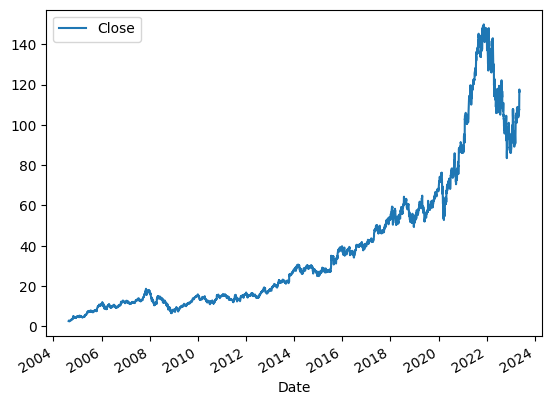

In [10]:
df.plot();

In [11]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,101.534500,102.066498,101.626503,101.623001
1,2021-03-26,102.066498,101.626503,101.623001,101.236504
2,2021-03-29,101.626503,101.623001,101.236504,102.289497
3,2021-03-30,101.623001,101.236504,102.289497,102.323502
4,2021-03-31,101.236504,102.289497,102.323502,103.125999
...,...,...,...,...,...
247,2022-03-17,125.950996,129.197998,133.280502,133.839005
248,2022-03-18,129.197998,133.280502,133.839005,136.125504
249,2022-03-21,133.280502,133.839005,136.125504,136.101501
250,2022-03-22,133.839005,136.125504,136.101501,139.867996


In [12]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

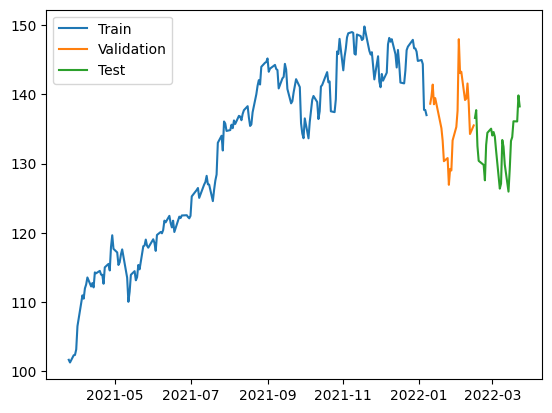

In [13]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test']);

In [14]:

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100);


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 17455.8633 - mean_absolute_error: 131.4992 - val_loss: 18487.0352 - val_mean_absolute_error: 135.8757
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17233.5430 - mean_absolute_error: 130.5774 - val_loss: 18299.7031 - val_mean_absolute_error: 135.1846
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16907.1270 - mean_absolute_error: 129.3743 - val_loss: 18092.2402 - val_mean_absolute_error: 134.4149
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17132.1836 - mean_absolute_error: 130.2517 - val_loss: 17809.8945 - val_mean_absolute_error: 133.3604
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16781.0957 - mean_absolute_error: 128.9229 - val_loss: 17434.6699 - val_mean_absolute_error: 131.9460
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16118.8525 - mean_absolute_error: 126.2399 - val_loss: 16943.9668 - val_mean_absolute_error: 130.0731
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/

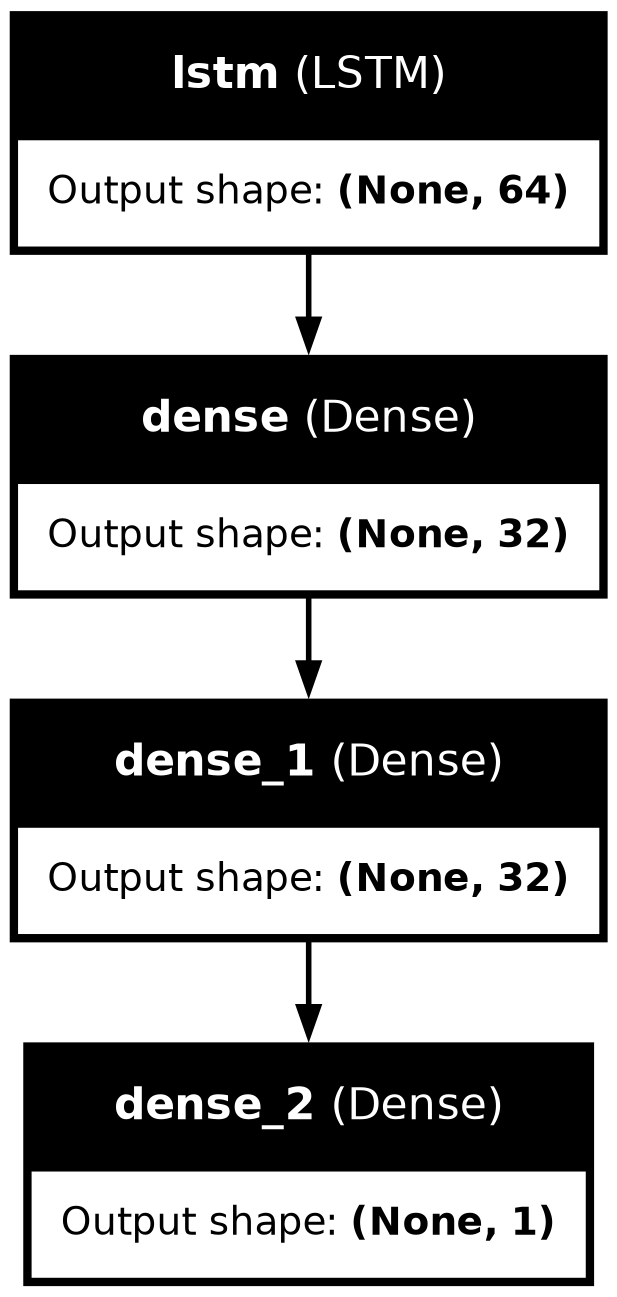

In [15]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


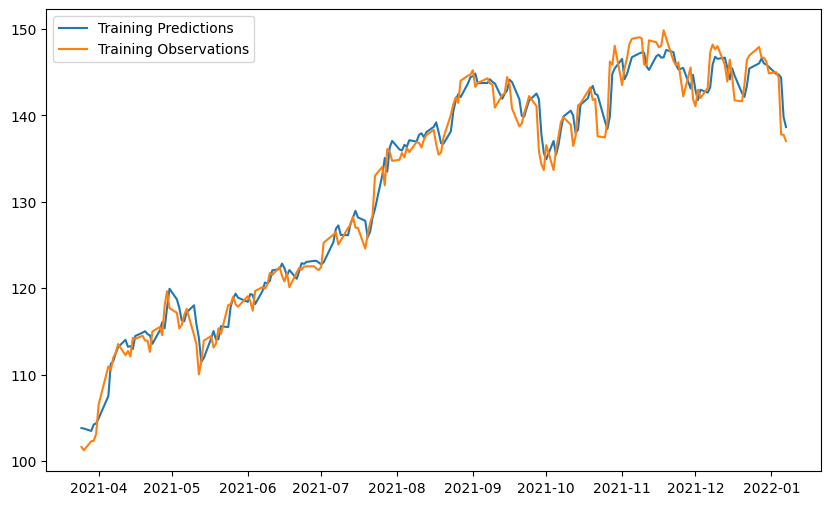

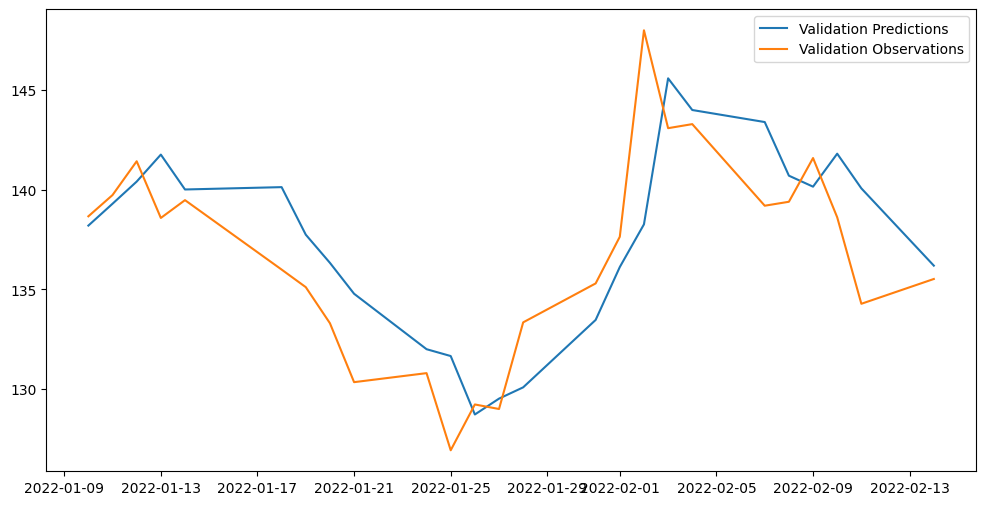

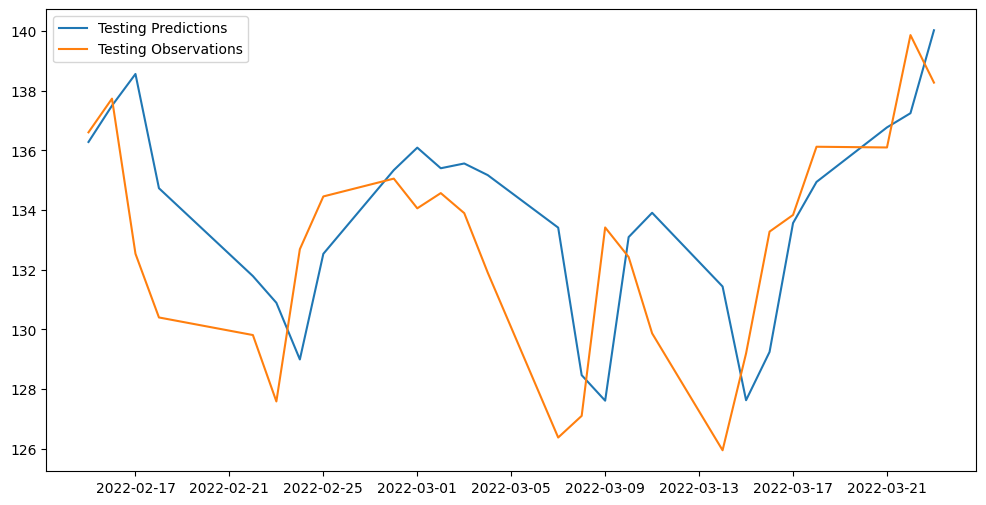

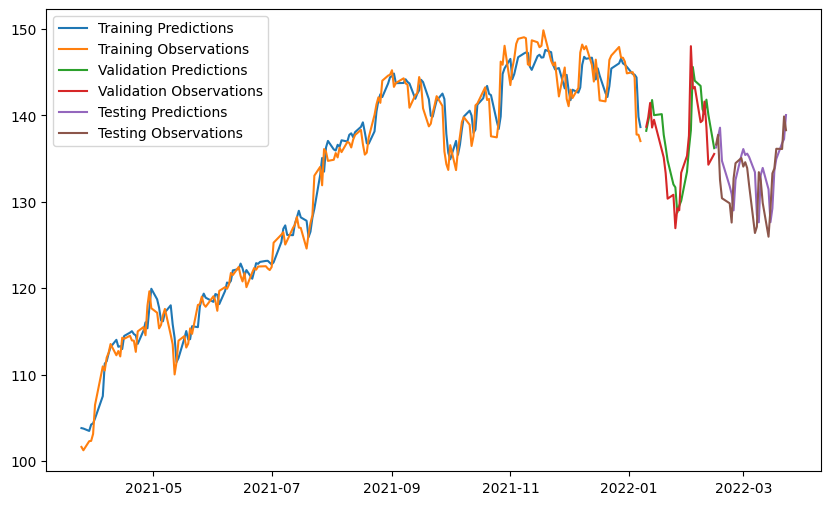

In [16]:
train_predictions = model.predict(X_train).flatten()

fig = plt.figure(figsize=(10, 6))

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations']);




val_predictions = model.predict(X_val).flatten()

fig = plt.figure(figsize=(12, 6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations']);



test_predictions = model.predict(X_test).flatten()
fig = plt.figure(figsize=(12, 6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations']);


fig = plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations']);

In [17]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

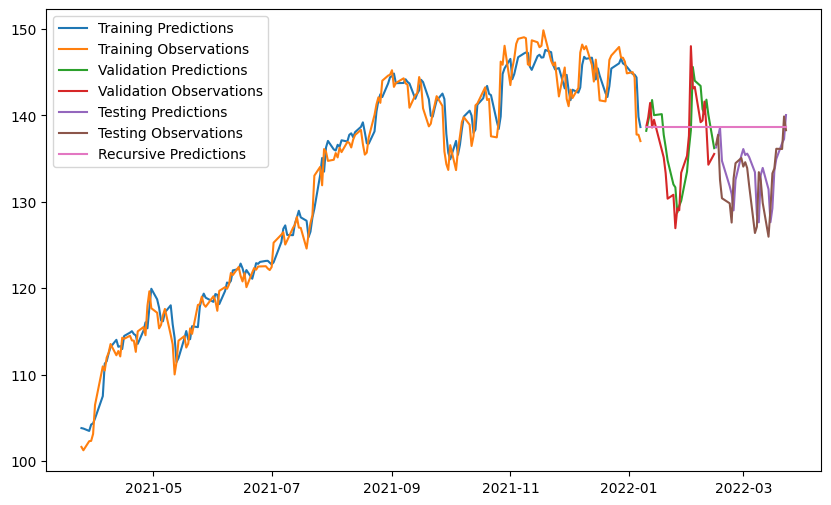

In [18]:
fig = plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions']);